# Step 3: 강화 학습을 사용하여 SAWYER를 선호하는 응답에 맞추기

__Our SAWYER Process__

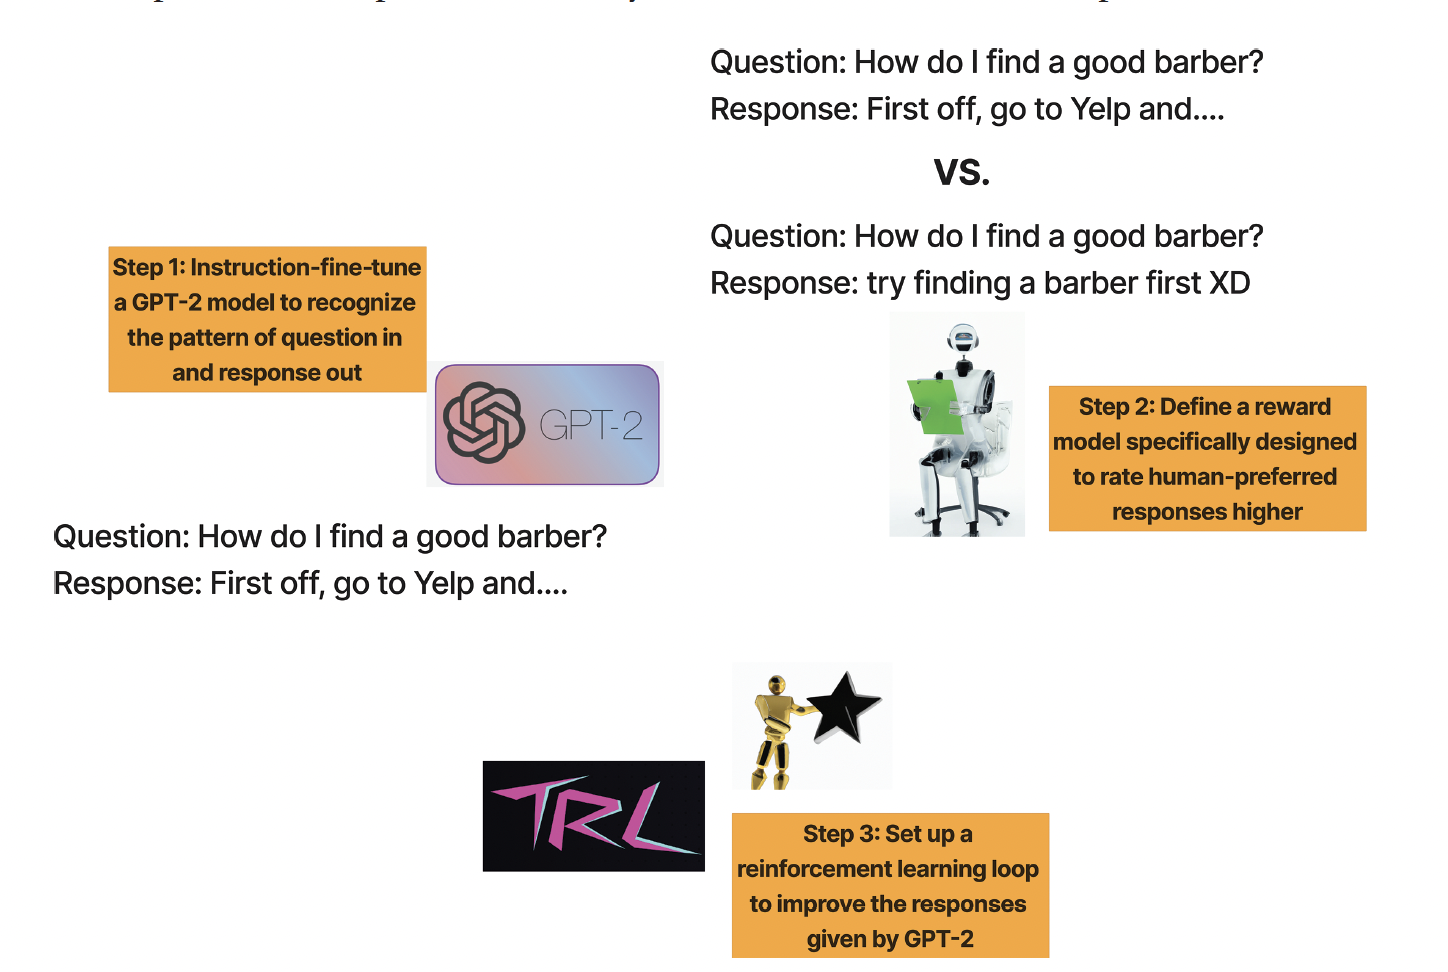

# 1. 초기화

In [1]:
!pip install datasets
!pip install trl
!pip install wandb

In [2]:
BASE_DIR = ""

In [3]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

In [4]:
###########################################
# 1-1. Google drive mount

if IN_COLAB == True:
    from google.colab import drive
    drive.mount('/content/drive')
    
    BASE_DIR = "/content/drive/MyDrive/Colab Notebooks/quick-start-guide-to-llms/notebooks/"

In [5]:
import os
import pandas as pd
import torch
from datasets import load_dataset
from tqdm import tqdm
from transformers import AutoTokenizer, HfArgumentParser, pipeline, AutoModelForSequenceClassification

from trl import AutoModelForCausalLMWithValueHead, PPOConfig, PPOTrainer, set_seed, create_reference_model
from trl.core import LengthSampler

from datasets import Dataset
tqdm.pandas()

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
# device = torch.device("cuda")
# device

Using device: cpu



# 2. 토크나이저 및 데이터 로딩

In [7]:
# load our custom tokenizer
tokenizer = AutoTokenizer.from_pretrained(BASE_DIR + "sawyer/tokenizer")
tokenizer.pad_token, tokenizer.pad_token_id

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


('<PAD>', 50259)

In [8]:
QUERY_KEY = "Question:"
RESPONSE_KEY = "Response:"
PAD_KEY = "<PAD>"

In [9]:
response_token_id = tokenizer.vocab[RESPONSE_KEY]
response_token_id

50258

In [10]:
dolly = load_dataset('databricks/databricks-dolly-15k')
dolly

DatasetDict({
    train: Dataset({
        features: ['instruction', 'context', 'response', 'category'],
        num_rows: 15011
    })
})

In [11]:
dolly['train'][0]

{'instruction': 'When did Virgin Australia start operating?',
 'context': "Virgin Australia, the trading name of Virgin Australia Airlines Pty Ltd, is an Australian-based airline. It is the largest airline by fleet size to use the Virgin brand. It commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route. It suddenly found itself as a major airline in Australia's domestic market after the collapse of Ansett Australia in September 2001. The airline has since grown to directly serve 32 cities in Australia, from hubs in Brisbane, Melbourne and Sydney.",
 'response': 'Virgin Australia commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route.',
 'category': 'closed_qa'}

In [12]:
dolly

DatasetDict({
    train: Dataset({
        features: ['instruction', 'context', 'response', 'category'],
        num_rows: 15011
    })
})

위의 코드는 데이터 전처리 함수인 `preprocess_function`을 정의하고 있습니다. 이 함수는 입력 데이터를 모델에 입력할 수 있는 형태로 변환하는 역할을 합니다.

함수의 동작을 단계별로 살펴보겠습니다:

1. `ascci` 함수는 입력 텍스트에서 ASCII 문자만 남기고 나머지 문자는 '?'로 대체하는 함수입니다. 이 함수는 입력 텍스트에 대한 전처리로 사용됩니다.

2. `preprocess_function` 함수는 `examples` 인자를 받습니다. 이 인자는 전처리할 데이터의 예시들을 포함하고 있습니다.

3. `new_examples` 딕셔너리를 초기화합니다. 이 딕셔너리는 전처리된 데이터를 저장하는 데 사용됩니다.
   - "input_ids": 입력 토큰 ID 리스트
   - "attention_mask": 어텐션 마스크 리스트
   - "input_text": 입력 텍스트 리스트

4. `examples["instruction"]`과 `examples['context']`를 `zip` 함수를 사용하여 페어로 묶어 반복합니다.

5. 각 `instruction`과 `context` 페어에 대해 다음 작업을 수행합니다:
   - `context`가 존재하는 경우:
     - `input_text`를 생성합니다. 형식은 `QUERY_KEY + ' ' + instruction + '\n\n' + context + '\n' + RESPONSE_KEY`입니다.
     - 이는 보상 모델과 동일한 구조를 가지도록 합니다.
   - `context`가 없는 경우:
     - `input_text`를 생성합니다. 형식은 `QUERY_KEY + ' ' + instruction + '\n' + RESPONSE_KEY`입니다.

6. `tokenizer`를 사용하여 `input_text`를 토큰화합니다. `return_tensors='pt'`로 설정하여 PyTorch 텐서 형태로 반환합니다.
   - 토큰화된 결과는 `tokenized_question` 변수에 저장됩니다.

7. `input_text`를 `new_examples['input_text']` 리스트에 추가합니다.

8. 토큰화된 입력의 토큰 ID와 어텐션 마스크를 각각 `new_examples["input_ids"]`와 `new_examples["attention_mask"]` 리스트에 추가합니다.

9. 전처리된 데이터를 담고 있는 `new_examples` 딕셔너리를 반환합니다.

이 함수는 데이터셋의 각 예시에 대해 호출되며, 전처리된 데이터를 모아 새로운 데이터셋을 생성하는 데 사용됩니다. 전처리 과정에서는 입력 텍스트를 생성하고 토크나이저를 사용하여 토큰화합니다. 생성된 입력 텍스트, 토큰 ID, 어텐션 마스크를 저장하여 모델 입력으로 사용할 수 있도록 준비합니다.

전처리된 데이터셋은 모델의 입력으로 사용되며, 모델은 이를 기반으로 학습하고 추론을 수행합니다.

In [13]:
# 일부 텍스트를 정리하는 빠른 정리 기능
def ascci(text): return ''.join(char if ord(char) < 128 else '?' for char in text)

def preprocess_function(examples):
    new_examples = {
        "input_ids": [],
        "attention_mask": [],
        "input_text": []
    }
    for instruction, context in zip(examples["instruction"], examples['context']):
        if context:
            # 보상 모델과 동일한 구조인지 확인
            input_text = QUERY_KEY+ ' ' + instruction + '\n\n' + context + '\n' + RESPONSE_KEY
        else:
            input_text = QUERY_KEY+ ' ' + instruction + '\n'+RESPONSE_KEY
        tokenized_question = tokenizer(input_text, return_tensors='pt')
        new_examples['input_text'].append(input_text)
        new_examples["input_ids"].append(tokenized_question["input_ids"])
        new_examples["attention_mask"].append(tokenized_question["attention_mask"])
    return new_examples

In [14]:
dolly = dolly.map(preprocess_function, batched=True, batch_size=64)

In [15]:
dolly.set_format(type="torch")

In [16]:
dolly = dolly.filter(lambda x: x["input_ids"].shape[-1] < 512, batched=False)

In [17]:
dolly

DatasetDict({
    train: Dataset({
        features: ['instruction', 'context', 'response', 'category', 'input_ids', 'attention_mask', 'input_text'],
        num_rows: 14559
    })
})

In [18]:
dolly['train'][0]

{'instruction': 'When did Virgin Australia start operating?',
 'context': "Virgin Australia, the trading name of Virgin Australia Airlines Pty Ltd, is an Australian-based airline. It is the largest airline by fleet size to use the Virgin brand. It commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route. It suddenly found itself as a major airline in Australia's domestic market after the collapse of Ansett Australia in September 2001. The airline has since grown to directly serve 32 cities in Australia, from hubs in Brisbane, Melbourne and Sydney.",
 'response': 'Virgin Australia commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route.',
 'category': 'closed_qa',
 'input_ids': tensor([[50257,  1649,   750,  5283,  4505,   923,  5361,    30,   198,   198,
          34674,  4505,    11,   262,  7313,  1438,   286,  5283,  4505, 16712,
            350,   774, 12052,    11,   318,   281,  6638,    12,  3106, 18091,
          

In [19]:
print(dolly['train'][0]['input_ids'])
print(tokenizer.batch_decode(dolly['train'][0]['input_ids']))

tensor([[50257,  1649,   750,  5283,  4505,   923,  5361,    30,   198,   198,
         34674,  4505,    11,   262,  7313,  1438,   286,  5283,  4505, 16712,
           350,   774, 12052,    11,   318,   281,  6638,    12,  3106, 18091,
            13,   632,   318,   262,  4387, 18091,   416, 11026,  2546,   284,
           779,   262,  5283,  4508,    13,   632, 32400,  2594,   319,  3261,
          2932,  4751,   355,  5283,  4518,    11,   351,   734,  6215,   319,
           257,  2060,  6339,    13,   632,  6451,  1043,  2346,   355,   257,
          1688, 18091,   287,  4505,   338,  5928,  1910,   706,   262,  9807,
           286,  1052, 17744,  4505,   287,  2693,  5878,    13,   383, 18091,
           468,  1201,  7334,   284,  3264,  4691,  3933,  4736,   287,  4505,
            11,   422, 38459,   287, 26914,    11, 14819,   290, 11852,    13,
           198, 50258]])
["Question: When did Virgin Australia start operating?\n\nVirgin Australia, the trading name of Virgin Aus

# 3. 트레이닝 준비

## 3.1 리워드 모델과 인스트럭션 튜닝 모델 로드

In [20]:
reward_model_name = BASE_DIR + 'sawyer_rm'

reward_model = AutoModelForSequenceClassification.from_pretrained(
    reward_model_name, num_labels=1,
).to(device)
reward_tokenizer = AutoTokenizer.from_pretrained('roberta-base')  # our tokenizer isn't different from base roberta

In [21]:
model = AutoModelForCausalLMWithValueHead.from_pretrained(BASE_DIR + 'sawyer').to(device)

## 3.2 PPO 관련 설정 및 트레이너 생성

다음 코드는 `PPOConfig` 클래스를 사용하여 PPO(Proximal Policy Optimization) 알고리즘의 하이퍼파라미터를 설정하는 부분입니다.

`PPOConfig` 클래스는 PPO 알고리즘을 사용할 때 필요한 다양한 하이퍼파라미터를 정의하고 설정할 수 있는 편리한 방법을 제공합니다.

코드에서 설정된 하이퍼파라미터를 살펴보겠습니다:

1. `model_name='sawyer_rl'`: 사용할 모델의 이름을 지정합니다. 여기서는 'sawyer_rl'이라는 이름을 사용하고 있습니다.

2. `learning_rate=1.4e-6`: 학습률을 설정합니다. 학습률은 모델의 가중치를 업데이트하는 크기를 결정합니다. 여기서는 1.4e-6으로 설정되어 있습니다.

3. `batch_size=128`: 배치 크기를 설정합니다. 배치 크기는 한 번의 반복(iteration)에서 사용되는 데이터의 샘플 수를 나타냅니다. 여기서는 128로 설정되어 있습니다.

4. `gradient_accumulation_steps=1`: 그래디언트 누적 단계를 설정합니다. 그래디언트 누적은 여러 배치에 대한 그래디언트를 누적하여 업데이트하는 기법입니다. 여기서는 1로 설정되어 있어 그래디언트 누적을 사용하지 않습니다.

5. `ppo_epochs=1`: PPO의 에포크 수를 설정합니다. PPO에서는 각 에포크마다 정책과 가치 함수를 업데이트합니다. 여기서는 1로 설정되어 있습니다.

6. `seed=42`: 난수 생성기의 시드(seed) 값을 설정합니다. 시드 값을 고정하면 실험 결과를 재현할 수 있습니다.

7. `log_with="wandb"`: 로깅 도구로 Weights & Biases(wandb)를 사용하도록 설정합니다. wandb는 머신러닝 실험을 추적하고 시각화하는 데 사용되는 플랫폼입니다.

8. `optimize_cuda_cache=True`: CUDA 캐시 최적화를 활성화합니다. 이 옵션은 GPU 메모리 사용량을 최적화하여 학습 속도를 향상시킬 수 있습니다.

위의 하이퍼파라미터 설정은 PPO 알고리즘을 사용하여 모델을 학습할 때 사용됩니다. 이러한 하이퍼파라미터는 모델의 성능과 학습 속도에 영향을 미치므로 적절한 값을 선택하는 것이 중요합니다.

`config` 객체를 생성한 후에는 `PPOTrainer` 클래스의 인자로 전달하여 PPO 학습을 수행할 수 있습니다.

예를 들어:
```python
trainer = PPOTrainer(config=config, model=model, train_dataset=train_dataset, eval_dataset=eval_dataset)
trainer.train()
```

위와 같이 `PPOTrainer` 클래스를 사용하여 `config` 객체와 함께 모델, 학습 데이터셋, 평가 데이터셋을 전달하고 `train()` 메서드를 호출하여 PPO 학습을 시작할 수 있습니다.

In [22]:
config = PPOConfig(
    model_name='sawyer_rl',
    learning_rate=1.4e-6,
    batch_size=4,  # 4 128
    # gradient_accumulation_steps=1,
    gradient_accumulation_steps=2,
    mini_batch_size=2,
    ppo_epochs=1,
    seed=42,
    log_with="wandb",
    optimize_cuda_cache=True
)

위의 코드는 데이터 콜레이터 함수인 `collator`를 정의하고 있습니다. 데이터 콜레이터는 데이터셋에서 샘플을 배치로 묶어주는 역할을 합니다.

`collator` 함수는 `data` 인자를 받습니다. `data`는 데이터셋에서 반환된 여러 개의 샘플을 포함하는 리스트입니다.

함수의 동작을 단계별로 살펴보겠습니다:

1. `return dict((key, [d[key] for d in data]) for key in data[0])` 코드는 딕셔너리 컴프리헨션(Dictionary Comprehension)을 사용하여 새로운 딕셔너리를 생성합니다.

2. `data[0]`은 `data` 리스트의 첫 번째 샘플을 나타냅니다. 이 샘플은 딕셔너리 형태로 되어 있다고 가정합니다.

3. `for key in data[0]` 코드는 첫 번째 샘플의 키(key)를 순회합니다. 이는 모든 샘플이 동일한 키를 가지고 있다고 가정합니다.

4. 각 키에 대해 `(key, [d[key] for d in data])`를 수행합니다. 이는 튜플을 생성하는데, 첫 번째 요소는 키(key)이고 두 번째 요소는 리스트 컴프리헨션의 결과입니다.

5. 리스트 컴프리헨션 `[d[key] for d in data]`는 `data` 리스트의 각 샘플 `d`에 대해 `d[key]`를 수행하여 해당 키에 대한 값을 추출하고, 그 결과를 리스트로 만듭니다.

6. 최종적으로 `dict()` 함수를 사용하여 생성된 튜플들을 딕셔너리로 변환하여 반환합니다.

예를 들어, `data`가 다음과 같다고 가정해보겠습니다:
```python
data = [
    {'input_ids': [1, 2, 3], 'attention_mask': [1, 1, 1]},
    {'input_ids': [4, 5, 6], 'attention_mask': [1, 1, 0]},
    {'input_ids': [7, 8, 9], 'attention_mask': [1, 0, 0]}
]
```

위의 `collator` 함수를 적용하면 다음과 같은 결과를 얻을 수 있습니다:
```python
{
    'input_ids': [[1, 2, 3], [4, 5, 6], [7, 8, 9]],
    'attention_mask': [[1, 1, 1], [1, 1, 0], [1, 0, 0]]
}
```

`collator` 함수는 각 키에 대해 `data`의 모든 샘플에서 해당 값을 추출하여 리스트로 만들어 반환합니다. 이렇게 생성된 딕셔너리는 배치 데이터를 나타내며, 모델에 입력으로 사용될 수 있습니다.

데이터 콜레이터는 `DataLoader`의 `collate_fn` 인자로 전달되어 배치 데이터를 생성하는 데 사용됩니다.

In [23]:
def collator(data):
    return dict((key, [d[key] for d in data]) for key in data[0])

In [24]:
set_seed(42)

위의 코드는 `PPOTrainer`를 생성하는 부분입니다. `PPOTrainer`는 PPO(Proximal Policy Optimization) 알고리즘을 사용하여 강화 학습 모델을 학습시키는 클래스입니다.

`PPOTrainer`의 생성자에는 다음과 같은 인자들이 전달됩니다:

1. `config`: PPO 알고리즘의 하이퍼파라미터를 정의한 `PPOConfig` 객체입니다. 이전에 생성한 `config` 객체를 전달합니다.

2. `model`: 학습할 모델 객체입니다. 강화 학습에서 사용되는 정책 네트워크(policy network)에 해당합니다.

3. `ref_model`: 참조 모델(reference model) 객체입니다. `create_reference_model(model)` 함수를 사용하여 생성한 참조 모델을 전달합니다. 참조 모델은 PPO 알고리즘에서 사용되는 가치 함수(value function)를 나타냅니다.

4. `tokenizer`: 토큰화 도구(tokenizer) 객체입니다. 전처리 과정에서 사용되는 토크나이저를 전달합니다.

5. `dataset`: 학습에 사용될 데이터셋입니다. `dolly['train']`은 학습 데이터셋을 나타냅니다.

6. `data_collator`: 데이터 콜레이터(data collator) 함수입니다. 이전에 정의한 `collator` 함수를 전달합니다. 데이터 콜레이터는 데이터셋에서 샘플을 배치로 묶어주는 역할을 합니다.

`PPOTrainer`는 전달된 인자들을 사용하여 PPO 알고리즘을 초기화하고, 모델 학습을 준비합니다.

`create_reference_model(model)` 함수는 입력으로 받은 `model`을 기반으로 참조 모델을 생성하는 함수입니다. 참조 모델은 PPO 알고리즘에서 사용되는 가치 함수를 나타내며, 일반적으로 정책 네트워크와 유사한 구조를 가집니다.

생성된 `ppo_trainer` 객체를 사용하여 강화 학습 모델을 학습시킬 수 있습니다. 학습을 시작하려면 `ppo_trainer.train()` 메서드를 호출하면 됩니다.

예를 들어:
```python
ppo_trainer.train()
```

위와 같이 `train()` 메서드를 호출하면 PPO 알고리즘을 사용하여 모델 학습이 시작됩니다. 학습 과정에서는 정책 네트워크와 가치 함수가 반복적으로 업데이트되며, 모델은 주어진 환경에서 최적의 행동을 학습하게 됩니다.

학습이 완료된 후에는 `ppo_trainer.save_model(path)` 메서드를 사용하여 학습된 모델을 저장할 수 있습니다. 저장된 모델은 추후에 로드하여 사용할 수 있습니다.

In [25]:
# 모델, 참조 모델, 토큰화 도구를 전달하여 PPOTrainer를 빌드합니다.
ppo_trainer = PPOTrainer(
    config,
    model,
    ref_model=create_reference_model(model),
    tokenizer=tokenizer,
    dataset=dolly['train'],
    data_collator=collator
)

wandb: Currently logged in as: kimwooglae. Use `wandb login --relogin` to force relogin


In [26]:
# 그런 다음 `generate` 함수에 전달할 인수를 정의합니다. 
# 이러한 인수는 학습된 모델의 `generate` 함수를 감싸는 래퍼인 PPOTrainer의 `generate` 함수에 전달됩니다.
generation_kwargs = {
    "do_sample": True,
    "pad_token_id": tokenizer.pad_token_id,
    "eos_token_id": tokenizer.eos_token_id,
    "max_new_tokens": 128,
}

In [27]:
output_length_sampler = LengthSampler(32, 1024)

In [28]:
EPOCHS=2

위의 코드는 강화 학습(Reinforcement Learning)을 사용하여 언어 모델을 fine-tuning하는 과정을 나타냅니다. 주요 내용은 다음과 같습니다:

1. `tqdm`을 사용하여 진행 상황을 표시하면서 `EPOCHS` 수만큼 반복합니다.

2. 각 epoch에서 `ppo_trainer.dataloader`에서 배치(batch)를 가져옵니다.

3. 각 배치에 대해 `response`, `query`, `rewards` 리스트를 초기화합니다.

4. 배치의 각 `input_ids`에 대해 다음 작업을 수행합니다:
   - `tokenizer.batch_decode()`를 사용하여 `input_ids`를 디코딩하고 `query` 리스트에 추가합니다.
   - `ppo_trainer.generate()`를 사용하여 주어진 `input_ids`에 대한 응답(response)을 생성합니다.
   - 생성된 응답 텐서에서 `response_token_id`의 첫 번째 등장 위치를 찾습니다.
   - 응답 텐서를 자르고 필요한 경우 차원을 조정합니다.
   - 응답을 디코딩하여 `response` 리스트에 추가하고, `response_tensors` 리스트에 응답 텐서를 추가합니다.

5. `reward_tokenizer`를 사용하여 쿼리(query)와 응답(response)을 인코딩합니다.

6. `reward_model`을 사용하여 응답에 대한 보상(reward)을 계산합니다.

7. 일정 간격(steps % 100 == 0)으로 현재 단계의 정보(보상 입력, 쿼리, 응답, 보상)를 출력합니다.

8. 계산된 보상을 `rewards` 리스트에 추가합니다.

9. `ppo_trainer.step()`을 호출하여 PPO 알고리즘의 한 단계를 수행합니다. 이 함수는 배치의 `input_ids`, 생성된 응답 텐서, 그리고 계산된 보상을 인자로 받습니다.

10. 주석 처리된 `ppo_trainer.log_stats()` 함수는 통계 정보를 로깅하는 역할을 합니다. 이 함수에서 NaN 값으로 인한 오류가 발생하여 주석 처리되었습니다.

11. `steps`를 증가시키고, 일정 간격(steps % 250 == 0)으로 현재까지의 단계 수를 출력합니다.

12. 일정 간격마다 `model.save_pretrained()`를 호출하여 현재 모델의 체크포인트를 저장합니다.

이 코드는 PPO 알고리즘을 사용하여 언어 모델을 fine-tuning하는 과정을 나타내며, 주어진 쿼리에 대한 응답을 생성하고 해당 응답에 대한 보상을 계산하여 모델을 업데이트합니다. 이를 통해 모델이 더 나은 응답을 생성하도록 학습됩니다.

In [29]:
from tqdm.auto import tqdm
steps = 0
for epoch in tqdm(range(EPOCHS)):
    print(epoch, len(ppo_trainer.dataloader))
    for batch in tqdm(ppo_trainer.dataloader):
        batch['response'] = []
        batch['query'] = []
        batch['rewards'] = []
        response_tensors = []
        # print(f"[{steps}] input_ids: {len(batch['input_ids'])}")
        for input_ids in batch["input_ids"]:
            batch['query'].append(tokenizer.batch_decode(input_ids, skip_special_tokens=True)[0])
            response_tensor = ppo_trainer.generate(
                input_ids.squeeze(), **generation_kwargs,
            )
            indices = torch.where(response_tensor == response_token_id)
            try:
                first_occurrence_index = indices[1][0].item()
            except:
                print('failure to find first_occurrence_index', response_tensor)
                print(tokenizer.batch_decode(response_tensor))
                first_occurrence_index = 0
            # Truncate the tensor grabbing all elements after the first occurrence
            response_tensor = response_tensor[:, first_occurrence_index+1:]
            if response_tensor.ndim == 0:
                response_tensor = response_tensor.unsqueeze(0).unsqueeze(0)
            if response_tensor.shape[-1] < 2:
                response_tensor = response_tensor.repeat(1, 4)
            batch['response'].append(tokenizer.batch_decode(response_tensor, skip_special_tokens=True)[0])
            response_tensors.append(response_tensor.squeeze())
            t = reward_tokenizer(batch['query'][-1].replace('Response:', '').strip(), batch['response'][-1], return_tensors='pt', truncation=True)
            try:
                r = reward_model(**t)
            except Exception as e:
                print("Exception occured:", e)
                print(t['input_ids'].shape)
            # if steps % 100 == 0:  # for some fun inspection
            #     print(f"[{steps}] REWARD_INPUT:",reward_tokenizer.batch_decode(t['input_ids'])[0][:100].replace('\n', ' '))
            #     print(f"[{steps}] QUERY:", batch['query'][-1][:100].replace('\n', ' '))
            #     print(f"[{steps}] RESPONSE:", batch['response'][-1][:100].replace('\n', ' '))

            # print(f"[{steps}] REWARD: {r.logits[0].item():.4f}\n")
                # print('REWARD_INPUT:', reward_tokenizer.batch_decode(t['input_ids'])[0])
                # print("QUERY:", batch['query'][-1], "RESPONSE:", batch['response'][-1], r.logits[0])

            batch['rewards'].append(r.logits[0])
        # Compute sentiment score NOTE that we are putting the query + response in the same format as training the reward model
        # Run PPO step

        try:
            stats = ppo_trainer.step([_.squeeze() for _ in batch["input_ids"]], response_tensors, batch['rewards'])
            ppo_trainer.log_stats(stats, batch, batch['rewards'])
        except Exception as e:
            print("Exception occured:", e)
            print("batch['input_ids']:", batch["input_ids"])
            print("[_.squeeze() for _ in batch['input_ids']]:", [_.squeeze() for _ in batch["input_ids"]])
            print("response_tensors:", response_tensors)
            print("batch['rewards']:", batch['rewards'])

        steps += 1
        if steps % 250 == 0:
            # print(batch)
            print(f"{steps} STEPS Saved")
            model.save_pretrained(f'./sawyer_rl/step_{steps}')

  0%|          | 0/2 [00:00<?, ?it/s]

0 3639


  0%|          | 0/3639 [00:00<?, ?it/s]

/Users/wlkim/anaconda3/envs/quick-start-guide-to-llms/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1222: UserWarning: The average ratio of batch (24.89) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/Users/wlkim/anaconda3/envs/quick-start-guide-to-llms/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1222: UserWarning: The average ratio of batch (4439097690577950980375052288.00) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Exception occured: autodetected range of [nan, nan] is not finite
batch['input_ids']: [tensor([[50257,  5338,   318, 35903, 15406,   198,   198,    51,  1437, 15406,
           357,  6286, 11735, 34673,  8266,   735,    26,  3389,  2608,    11,
         24414,     8,   318,   281,  1605,    12,  6286,   290,  3288,  1143,
         14780,  9880, 14015,    11, 38619,   290, 14549,    13, 23399,   306,
          6412,   284,   355,   262,   366, 32466,   286,  4631,   705,    77,
             6,  8299,  1600,   673,  8278,   284, 31198,   355,   262,  1085,
         14015,   286,   262, 34880,  1222, 35903, 15406,  5416,   518,   878,
         13925,   257,  4388,  3451,   355,   257, 12199, 26960,    13,   198,
           198, 17278,   263,  2540,   607,  3451,   351, 34880, 15406,   338,
         10578,   286, 45757,   287, 25177,    13,  4698,   262,  1438,  7703,
          5506,    11,   673,  4120,   319,   607,   717,  1700,    11,   366,
         16635,   742,   404,  1600,   287, 

KeyboardInterrupt: 

In [ ]:
model.save_pretrained(BASE_DIR + 'sawyer_rl')